In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly_express as px
import pandas_profiling

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#this allows us to see all of our columns or rows in jupyter notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#filter future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#set our code up so that it doesn't display scientific notation, we want full numbers
pd.set_option('display.float_format', '{:.2f}'.format)

ModuleNotFoundError: No module named 'plotly_express'

In [46]:
#load our data in
train = pd.read_csv('train.csv')

#drop outliers in the train set at the start (refer to the outlier detection section of this notebook for why this code is executed here)
train.drop(train.index[[8236, 4377]], inplace = True)

labels = pd.read_csv('labels.csv')
test = pd.read_csv('test.csv')
data = pd.merge(train, labels)
#create distinguising flags for test and train set
test['testflag'] = 1
#concatenate train and test data
data = pd.concat([data, test])

#move our labels to the end of the new dataset
data = data[[col for col in data.columns if col != 'poverty_probability' ] + ['poverty_probability']]

#check out the head of the data
data.head()

,active_bank_user,active_formal_nbfi_user,active_informal_nbfi_user,active_mm_user,advanced_phone_use,age,avg_shock_strength_last_year,bank_interest_rate,borrowed_for_daily_expenses_last_year,borrowed_for_emergency_last_year,borrowed_for_home_or_biz_last_year,borrowing_recency,can_add,can_calc_compounding,can_calc_percents,can_call,can_divide,can_make_transaction,can_text,can_use_internet,cash_property_savings,country,education_level,employed_last_year,employment_category_last_year,employment_type_last_year,female,financially_included,formal_savings,has_insurance,has_investment,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,informal_savings,is_urban,literacy,married,mfi_interest_rate,mm_interest_rate,nonreg_active_mm_user,num_financial_activities_last_year,num_formal_institutions_last_year,num_informal_institutions_last_year,num_shocks_last_year,num_times_borrowed_last_year,other_fsp_interest_rate,phone_ownership,phone_technology,reg_bank_acct,reg_formal_nbfi_account,reg_mm_acct,relationship_to_hh_head,religion,row_id,share_hh_income_provided,testflag,poverty_probability
0,True,False,False,False,False,18.00,0.00,nan,False,False,False,0,True,True,True,True,True,False,True,False,False,C,1.00,False,housewife_or_student,not_working,True,True,False,False,False,False,False,False,False,False,False,False,False,True,True,nan,nan,False,1,1,0,0,0,nan,1,0,True,False,False,Other,P,0,1.00,nan,0.52
1,True,False,False,False,False,30.00,0.00,nan,False,False,False,0,True,False,False,True,True,False,False,False,False,C,1.00,False,housewife_or_student,not_working,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,nan,nan,False,0,1,0,0,0,nan,2,1,True,False,False,Other,P,1,nan,nan,0.98
2,False,False,False,False,False,20.00,0.00,nan,False,False,False,2,True,False,True,True,True,False,False,False,False,A,1.00,True,employed,irregular_seasonal,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,nan,nan,False,0,0,0,0,1,nan,2,1,False,False,False,Spouse,Q,2,1.00,nan,0.98
3,False,False,False,False,False,61.00,0.00,nan,False,False,False,0,True,True,False,True,True,False,False,False,False,A,0.00,True,employed,self_employed,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,nan,nan,False,0,0,0,0,0,nan,0,0,False,False,False,Head,Q,3,nan,nan,0.88
4,False,False,False,False,False,26.00,0.00,nan,False,False,False,0,False,False,False,True,True,True,True,False,True,D,1.00,False,housewife_or_student,not_working,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,nan,nan,False,3,1,0,0,0,nan,1,0,False,False,False,Spouse,X,4,2.00,nan,0.80


In [47]:
# Printing the percentage of missing values per column
def percent_missing(dataframe):
    '''
    Prints the percentage of missing values for each column in a dataframe
    '''
    # Summing the number of missing values per column and then dividing by the total
    sumMissing = dataframe.isnull().values.sum(axis=0)
    pctMissing = sumMissing / dataframe.shape[0]
    
    if sumMissing.sum() == 0:
        print('No missing values')
    else:
        # Looping through and printing out each columns missing value percentage
        print('Percent Missing Values:', '\n')
        for idx, col in enumerate(dataframe.columns):
            if sumMissing[idx] > 0:
                print('{0}: {1:.2f}%'.format(col, pctMissing[idx] * 100))

__Using Pandas Profiling to create descriptive report__

In [48]:
profile = data.profile_report()
profile.get_rejected_variables(threshold=0.9)  # Rejected variables w/ high correlation
profile

AttributeError: 'DataFrame' object has no attribute 'profile_report'

# Let's fill in the missing values 
- we are going to try both removing and imputing 0s for bank_interest_rate becuase it is missing almost all of its values
- we are going to try and fill in education_level with a median encoded value
- we are going to try both dropping and imputing 0s for mfi_interest_rate becuase it is missing almost all of its values
- we are going to try dropping and imputing 0s for mm_interest_rate because it is missing almost all of its values
- we are going to try dropping and imputing 0s for other_fsp_interest_rate becuase it is missing almost all of its values
- we are going to impute for the missing values in share_hh_income_provided

In [49]:
#----------tried dropping them and imputing, don't see much of a difference
# unlucky_columns = ['bank_interest_rate', 'mfi_interest_rate', 'mm_interest_rate', 'other_fsp_interest_rate']
# data.drop(unlucky_columns, axis=1, inplace=True)
data['bank_interest_rate'].fillna(0, inplace = True)
data['mfi_interest_rate'].fillna(0, inplace = True)
data['mm_interest_rate'].fillna(0, inplace = True)
data['other_fsp_interest_rate'].fillna(0, inplace = True)

In [50]:
percent_missing(data)

Percent Missing Values: 

education_level: 1.83%
share_hh_income_provided: 2.37%
testflag: 60.00%
poverty_probability: 40.00%


__Now lets explore education_level__
- education_level - Highest level of education (0=no education, 1=primary education, 2=secondary education, 3=higher education)

Education level is correlated pretty well with literacy (.59), so I am going to try to fill in these cases based on literacy

In [51]:
data['education_level'] = data.groupby('literacy').education_level.transform(lambda x: x.replace(np.nan, x.median()))

In [52]:
data.groupby('literacy').education_level.mean()

literacy
False   0.65
True    1.74
Name: education_level, dtype: float64

I think that this is ok, but should check to see if we need to make these values whole numbers or not?

In [53]:
data['education_level'].unique()

array([1., 0., 2., 3.])

In [54]:
percent_missing(data)

Percent Missing Values: 

share_hh_income_provided: 2.37%
testflag: 60.00%
poverty_probability: 40.00%


__Now I want to look at share_hh_income_provided__
-  Share of household income provided

In [55]:
data['share_hh_income_provided'].unique()

array([ 1., nan,  2.,  5.,  3.,  4.])

This feature is correlated (.46) with employed_last_year, so lets impute based on the mean of that

In [56]:
data['share_hh_income_provided'] = data.groupby('employed_last_year').share_hh_income_provided.transform(lambda x: x.replace(np.nan, x.median()))

In [57]:
percent_missing(data)

Percent Missing Values: 

testflag: 60.00%
poverty_probability: 40.00%


# Data Visulization

Looks like rural areas in this sample are higher in poverty rates

<Figure size 720x360 with 0 Axes>

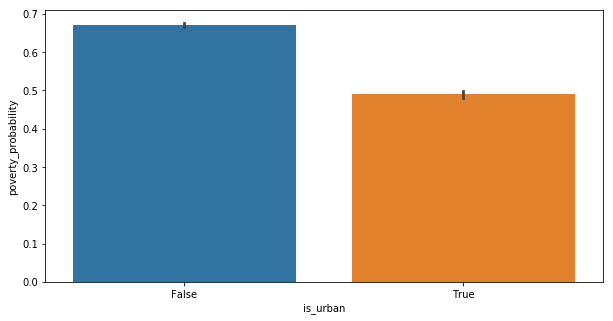

In [58]:
plt.figure(figsize = (10, 5))
sns.barplot(data=data, x = 'is_urban', y = 'poverty_probability')

__Plot poverty_probability by country and gender__

country
A   0.75
C   0.61
D   0.78
F   0.51
G   0.55
I   0.53
J   0.55
Name: poverty_probability, dtype: float64

<Figure size 1440x720 with 0 Axes>

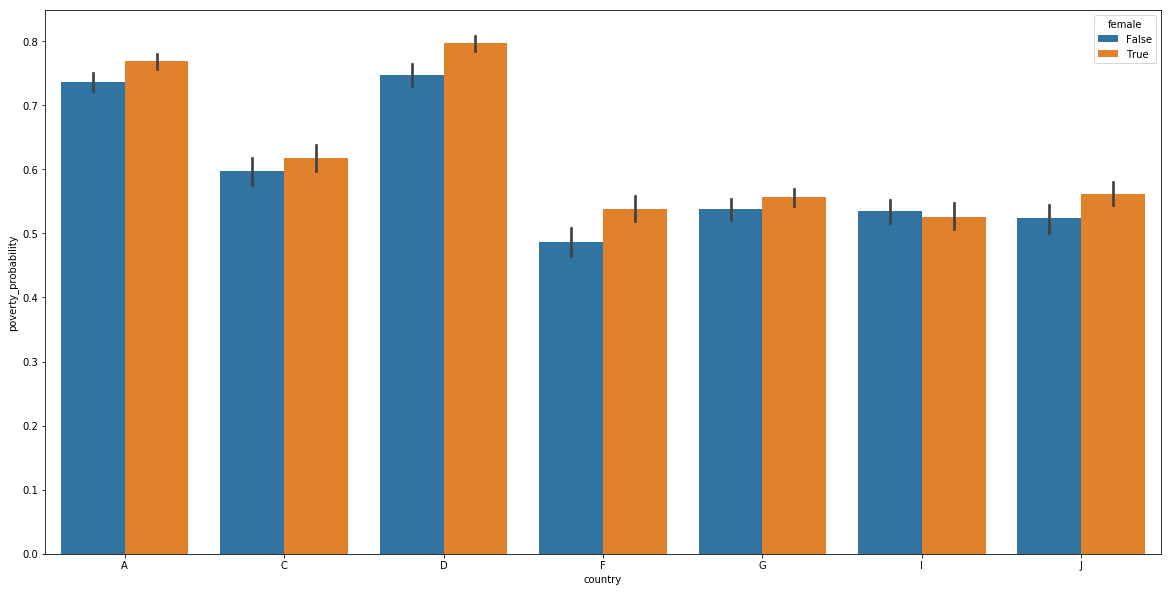

In [59]:
data.groupby('country').poverty_probability.mean()
#plot countries in sorted order
plt.figure(figsize=(20, 10))
sns.barplot(data = data.sort_values(by = ['country']), x = 'country', y = 'poverty_probability', hue = 'female')

__No strong relationship between age and poverty__

<Figure size 2160x1440 with 0 Axes>

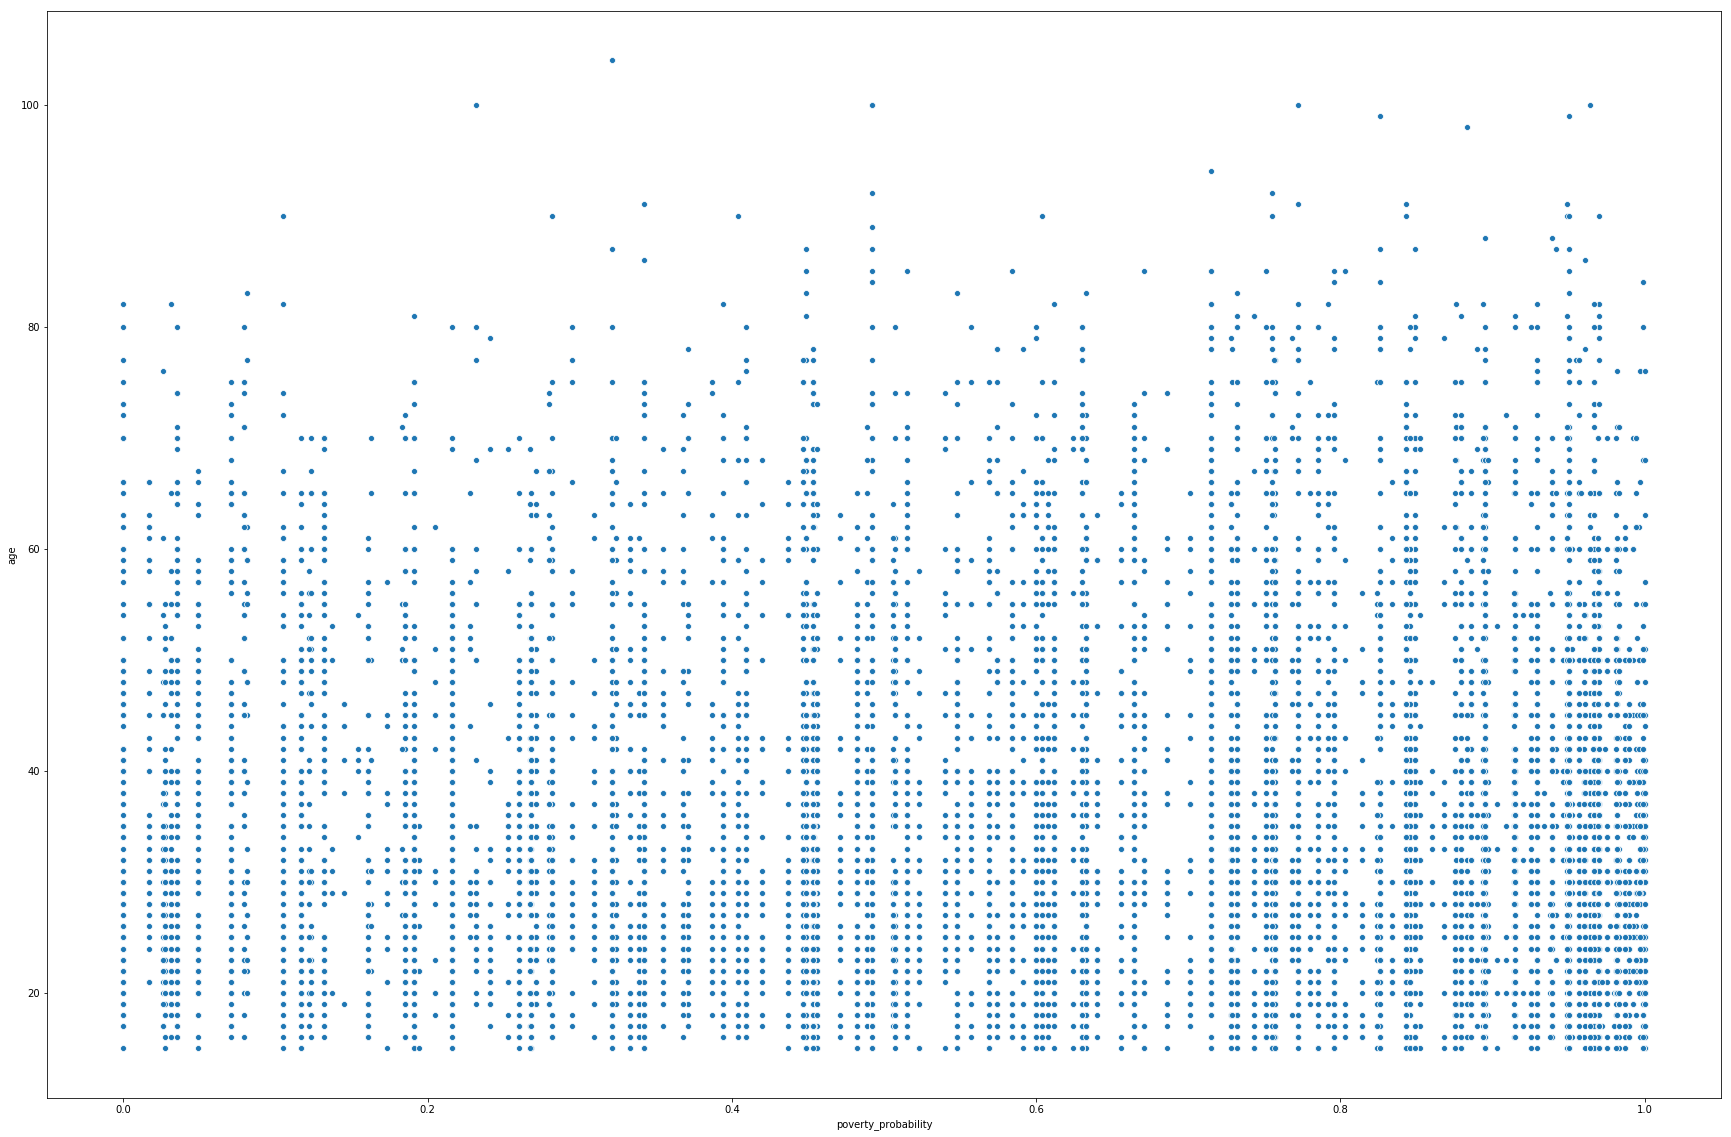

In [60]:
plt.figure(figsize=(30, 20))
sns.scatterplot(data = data, x = 'poverty_probability', y = 'age')

__Comparing men and women in poverty by education level__

female  education_level
False   0.00              0.71
        1.00              0.68
        2.00              0.53
        3.00              0.40
True    0.00              0.71
        1.00              0.70
        2.00              0.52
        3.00              0.38
Name: poverty_probability, dtype: float64

<Figure size 1440x720 with 0 Axes>

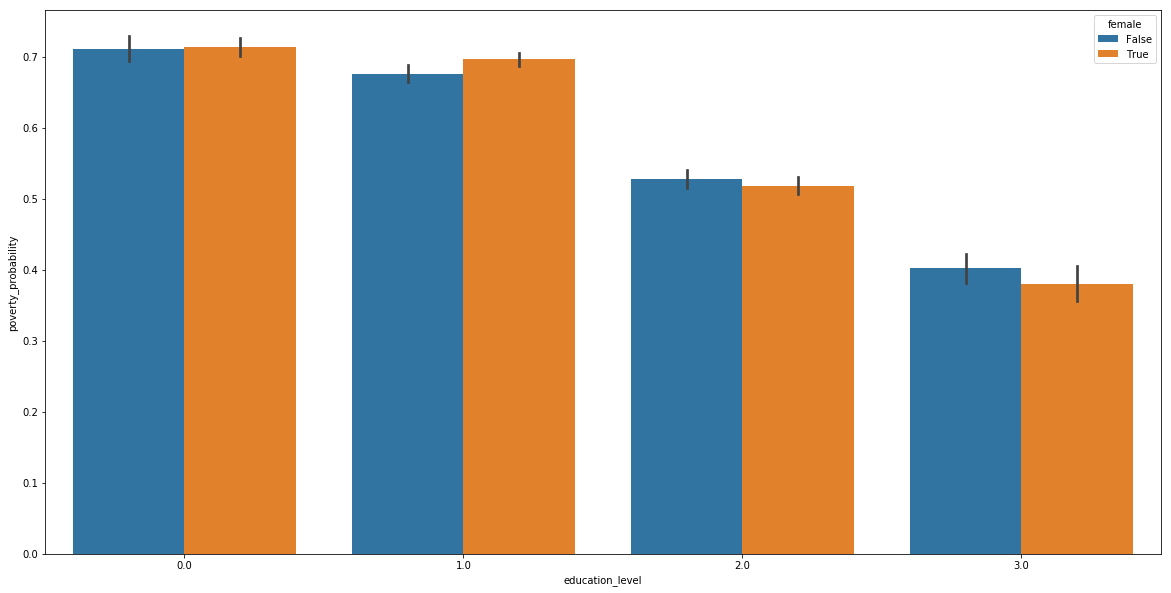

In [61]:
data.groupby(['female', 'education_level']).poverty_probability.mean()
plt.figure(figsize=(20, 10))
sns.barplot(data = data, x = 'education_level', y = 'poverty_probability', hue = 'female')

In [62]:
poverty_data = data[data['poverty_probability'] > .5]

In [63]:
poverty_data.groupby('country').poverty_probability.mean()

country
A   0.80
C   0.82
D   0.84
F   0.81
G   0.71
I   0.77
J   0.80
Name: poverty_probability, dtype: float64

# Outlier Detection
- I am going to begin by looking at the age outliers and removing any high ages

In [64]:
def boxplot(X):
    plt.figure(figsize = (10, 5))
    sns.boxplot(X)
    return sns.boxplot(X)

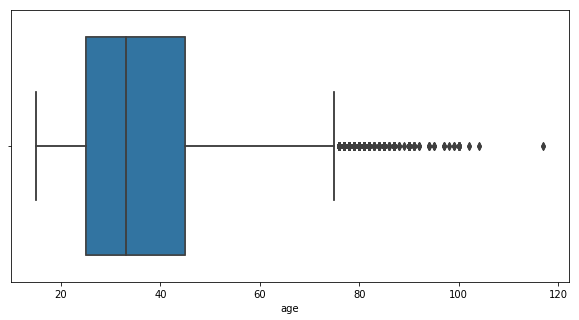

In [65]:
boxplot(data['age'])

In [66]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(data['age']))
print(z)

[1.20812022 0.41876067 1.0765603  ... 1.01078033 0.28720074 0.68188052]


In [67]:
age_outliers = np.where(z > 3)

In [68]:
age_outliers

(array([  197,   329,   372,   466,   830,   854,   878,  1093,  1238,
         1355,  1504,  1672,  1768,  1989,  2022,  2300,  2402,  3309,
         3695,  3896,  3983,  4187,  4212,  4335,  4919,  5545,  5580,
         5833,  5921,  5939,  6367,  6427,  6744,  6968,  7399,  7516,
         7757,  7997,  8056,  8245,  8256,  8274,  8316,  8592,  8704,
         9024,  9053,  9113,  9327,  9332,  9596,  9722,  9826,  9866,
         9867, 10019, 10156, 10340, 10525, 10564, 10567, 10594, 10797,
        10828, 11053, 11292, 11572, 11755, 11930, 12015, 12038, 12594,
        12625, 12714, 13099, 13560, 13949, 13980, 14202, 14387, 14654,
        14679, 14746, 14889, 14957, 15139, 15187, 15239, 15504, 16127,
        16130, 16456, 16533, 16558, 16933, 16975, 17068, 17113, 17370,
        17570, 17685, 18091, 18099, 18136, 19026, 19178, 19190, 19193,
        19305, 19333, 19413, 19683, 19713, 19812, 20022, 20078, 20258,
        20368, 20376, 20421, 20448, 20695, 20789], dtype=int64),)

In [69]:
# data.drop(data.index[[197,   372,   466,   830,   854,   878,  1238,  1355,  1504,
#          1672,  1768,  1989,  2300,  2402,  3309,  3695,  3983,  4187,
#          4212,  4335,  4920,  5546,  5940,  6368,  6428,  6745,  7517,
#          7758,  8057,  8236,  8247,  8258,  8276,  8318,  8594,  8706,
#          9026,  9055,  9115,  9329,  9334,  9598,  9724,  9828,  9869,
#         10021, 10158, 10342, 10527, 10566, 10569, 10596, 10799, 10830,
#         11055, 11294, 11757, 12040, 12596, 12627, 12716, 13101, 13562,
#         13982, 14204, 14389, 14656, 14681, 14748, 14891, 15141, 15189,
#         15241, 15506, 16129, 16132, 16458, 16535, 16560, 16935, 16977,
#         17070, 17115, 17372, 17572, 17687, 18093, 18101, 18138, 19028,
#         19180, 19192, 19195, 19307, 19335, 19415, 19685, 19715, 19814,
#         20024, 20080, 20260, 20370, 20378, 20423, 20450, 20697, 20791]], inplace = True)

In [70]:
data[data['age'] > 100]

,active_bank_user,active_formal_nbfi_user,active_informal_nbfi_user,active_mm_user,advanced_phone_use,age,avg_shock_strength_last_year,bank_interest_rate,borrowed_for_daily_expenses_last_year,borrowed_for_emergency_last_year,borrowed_for_home_or_biz_last_year,borrowing_recency,can_add,can_calc_compounding,can_calc_percents,can_call,can_divide,can_make_transaction,can_text,can_use_internet,cash_property_savings,country,education_level,employed_last_year,employment_category_last_year,employment_type_last_year,female,financially_included,formal_savings,has_insurance,has_investment,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,informal_savings,is_urban,literacy,married,mfi_interest_rate,mm_interest_rate,nonreg_active_mm_user,num_financial_activities_last_year,num_formal_institutions_last_year,num_informal_institutions_last_year,num_shocks_last_year,num_times_borrowed_last_year,other_fsp_interest_rate,phone_ownership,phone_technology,reg_bank_acct,reg_formal_nbfi_account,reg_mm_acct,relationship_to_hh_head,religion,row_id,share_hh_income_provided,testflag,poverty_probability
9722,True,False,False,False,True,104.00,0.00,0.00,False,False,False,0,True,True,False,True,True,False,False,False,False,F,1.00,False,retired_or_disabled,not_working,False,True,True,False,False,True,True,True,False,False,False,False,True,False,True,0.00,0.00,False,1,1,0,0,0,0.00,2,1,True,False,False,Head,Q,9724,2.00,nan,0.32
2056,True,False,False,False,True,102.00,4.00,0.00,False,False,False,0,True,True,True,False,True,True,True,False,False,F,3.00,True,employed,salaried,False,True,False,False,False,True,True,True,False,False,True,False,True,True,True,0.00,0.00,False,4,1,0,1,0,0.00,2,3,True,False,False,Head,Q,2056,4.00,1.00,nan
4377,False,False,False,False,False,117.00,1.00,0.00,False,False,False,0,False,False,False,True,False,False,False,False,False,F,0.00,False,retired_or_disabled,not_working,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,0.00,0.00,False,0,0,0,2,0,0.00,1,0,False,False,False,Head,X,4377,1.00,1.00,nan


In [71]:
test[test['age'] > 100]

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,employed_last_year,employment_category_last_year,employment_type_last_year,share_hh_income_provided,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,has_insurance,has_investment,bank_interest_rate,mm_interest_rate,mfi_interest_rate,other_fsp_interest_rate,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,advanced_phone_use,reg_bank_acct,reg_mm_acct,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,testflag
2056,2056,F,True,102.00,False,True,Q,Head,3.00,True,True,True,True,True,True,employed,salaried,4.00,True,True,True,False,False,True,0,0,False,False,False,False,False,nan,nan,nan,nan,1,4.00,False,False,False,3,False,True,False,True,2,True,True,False,False,True,True,False,False,False,False,1,0,4,1
4377,4377,F,False,117.00,True,True,X,Head,0.00,False,False,False,False,False,False,retired_or_disabled,not_working,1.00,True,True,False,False,False,False,0,0,False,False,False,False,False,nan,nan,nan,nan,2,1.00,False,False,False,0,True,False,False,False,1,False,False,False,False,False,False,False,False,False,False,0,0,0,1


__Since the oldest person alive, ever, is 116 years old, I am going to drop the 115 and 117 year-old values, since these are pretty unbelievable, whereas the 104 and 102 are semi-believable__
- So, the model improved significantly after removing these from the training set, one quirk here is that I had to drop them at the beginning of this notebook prior to concatenating the training and test sets for EDA, I had to do this becuase when I was making predictions for submission, the submissions were coming up two rows short, weird huh?, I'm sure this is a simple bug fix, but instead of diving into why this happened, I simply removed these outliers at the very beginning and called it a day

In [72]:
#had to remove these from the training set before concatenating my training and test sets, it was forcing the predictions to be two rows short
# data.drop(data.index[[8236, 4377]], inplace = True)

I removed all of these outliers previously and the model became worse, so I am going to leave them in for now

__Now I want to look at the remaining numeric columns__

In [73]:
data.select_dtypes(include = ['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20998 entries, 0 to 8399
Data columns (total 19 columns):
age                                    20998 non-null float64
avg_shock_strength_last_year           20998 non-null float64
bank_interest_rate                     20998 non-null float64
borrowing_recency                      20998 non-null int64
education_level                        20998 non-null float64
mfi_interest_rate                      20998 non-null float64
mm_interest_rate                       20998 non-null float64
num_financial_activities_last_year     20998 non-null int64
num_formal_institutions_last_year      20998 non-null int64
num_informal_institutions_last_year    20998 non-null int64
num_shocks_last_year                   20998 non-null int64
num_times_borrowed_last_year           20998 non-null int64
other_fsp_interest_rate                20998 non-null float64
phone_ownership                        20998 non-null int64
phone_technology                      

__Getting boxplots for all the major numeric features, looking for outliers__

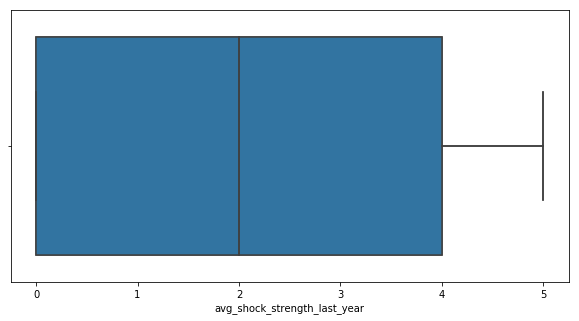

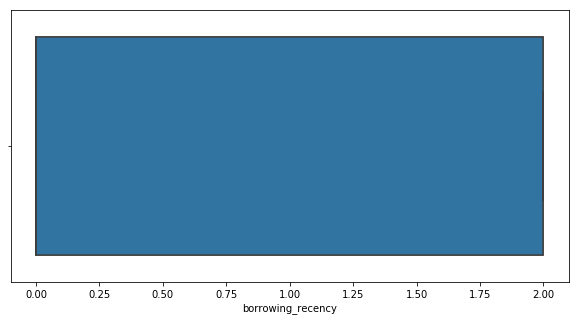

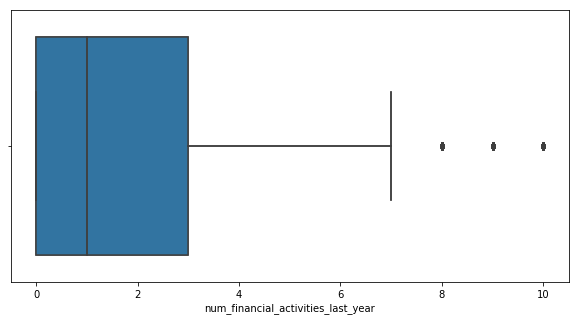

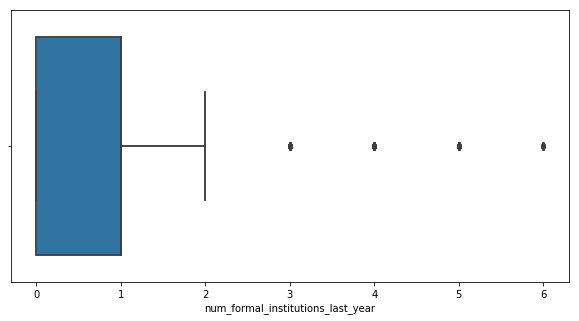

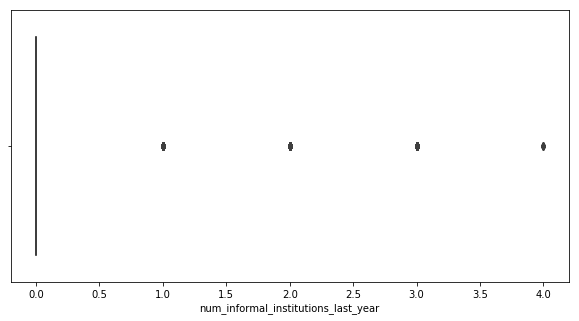

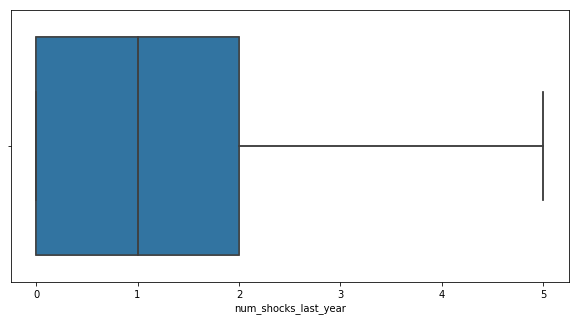

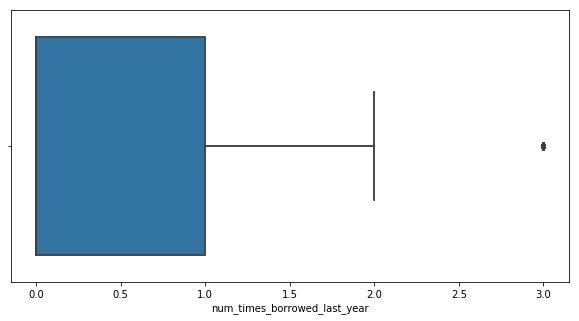

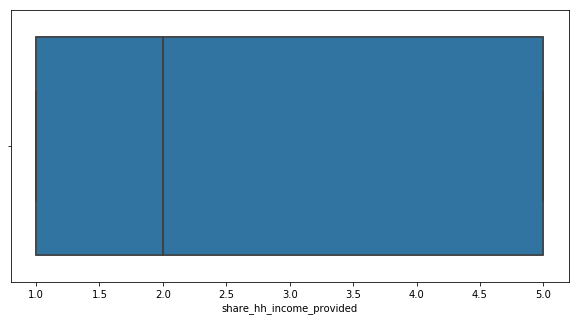

In [74]:
boxplot(data['avg_shock_strength_last_year'])
boxplot(data['borrowing_recency'])
boxplot(data['num_financial_activities_last_year'])
boxplot(data['num_formal_institutions_last_year'])
boxplot(data['num_informal_institutions_last_year'])
boxplot(data['num_shocks_last_year'])
boxplot(data['num_times_borrowed_last_year'])
boxplot(data['share_hh_income_provided'])

__I want to start with number of financial activities last year__

In [75]:
train['num_financial_activities_last_year'].value_counts()

0     5886
1     2041
2     1424
3     1078
4      841
5      562
6      334
7      206
8      152
9       48
10      26
Name: num_financial_activities_last_year, dtype: int64

__Now I want to look at number of formal institutions last year__

In [76]:
train['num_formal_institutions_last_year'].value_counts()

0    5802
1    5066
2    1373
3     263
4      78
5      13
6       3
Name: num_formal_institutions_last_year, dtype: int64

In [77]:
#----------------------the model performs worse when we drop these outliers
# #drop outliers
# institution_outliers_df = train[train['num_formal_institutions_last_year'] > 5]
# train.drop(institution_outliers_df.index, axis = 0, inplace=True)

In [78]:
# #check to see that it worked
# train['num_formal_institutions_last_year'].value_counts()

__Now I want to look at times borrowed last year__

In [79]:
train['num_times_borrowed_last_year'].value_counts()

0    7512
1    2653
2    1666
3     767
Name: num_times_borrowed_last_year, dtype: int64

__-------------NOTE: I removed all of these outliers and validated various models afterward, the models performed worse after removing these, so I have left the outliers detected above in the data aside from the two age outliers----------------------------__

# Feature Engineering

__Here I want to begin with looking at features to create within the education features__

In [80]:
#I am going to add together all of the "can" and "literacy" features to get a total score of ability
ed_mapper = {'False':0, 'True':1}
data['literacy'] = data['literacy'].astype(str)
data['literacy'].replace(ed_mapper, inplace = True)

data['can_add'] = data['can_add'].astype(str)
data['can_add'].replace(ed_mapper, inplace = True)

data['can_divide'] = data['can_divide'].astype(str)
data['can_divide'].replace(ed_mapper, inplace = True)

data['can_calc_percents'] = data['can_calc_percents'].astype(str)
data['can_calc_percents'].replace(ed_mapper, inplace=True)

data['can_calc_compounding'] = data['can_calc_compounding'].astype(str)
data['can_calc_compounding'].replace(ed_mapper, inplace=True)

data['education_skills'] = data['literacy'] + data['can_add'] + data['can_divide'] + data['can_calc_percents'] + data['can_calc_compounding']

In [81]:
data['education_skills'].corr(data['poverty_probability'])

-0.1482227700113392

In [82]:
#see if we can multiply our education level by the education skills category to get overall intelligence level?
data['overall_cognitive_ability'] = data['education_skills'] * data['education_level']
data['overall_cognitive_ability'].corr(data['poverty_probability'])

-0.3245572513116057

__Now I want to look at phone use, aggregating can_call, can_text, can_use_internet, can_make_transaction, and advanced_phone_use in order to create an overall phone use score__

In [83]:
phone_mapper = {'False':0, 'True':1}
data['can_call'] = data['can_call'].astype(str)
data['can_call'].replace(ed_mapper, inplace = True)

data['can_text'] = data['can_text'].astype(str)
data['can_text'].replace(ed_mapper, inplace = True)

data['can_use_internet'] = data['can_use_internet'].astype(str)
data['can_use_internet'].replace(ed_mapper, inplace = True)

data['can_make_transaction'] = data['can_make_transaction'].astype(str)
data['can_make_transaction'].replace(ed_mapper, inplace = True)

data['advanced_phone_use'] = data['advanced_phone_use'].astype(str)
data['advanced_phone_use'].replace(ed_mapper, inplace = True)

data['phone_mastery'] = data['can_call'] + data['can_text'] + data['can_use_internet'] + data['can_make_transaction'] + data['advanced_phone_use']

In [84]:
data['phone_mastery'].corr(data['poverty_probability'])

-0.3259091693078071

__Now I am going to look at borrowing information about each person__

In [85]:
#I want to look for relationships between the amount that someone is borrowing and the amount of income that the individual provides for their household
data['borrowed/share_hh_income'] = data['num_times_borrowed_last_year'] / data['share_hh_income_provided']
data['borrowed/share_hh_income'].corr(data['poverty_probability'])

0.052171730615034405

In [86]:
#looking at number of financial shocks experienced and shock strength
data['financial_shock_magnitude'] = data['num_shocks_last_year']*data['avg_shock_strength_last_year']
data['financial_shock_magnitude'].corr(data['poverty_probability'])

0.12895217258917474

In [87]:
#adding together interest rates to get a picture of a total interest rate if a person has more than one loan
data['total_current_interest'] = data['bank_interest_rate'] + data['mfi_interest_rate'] + data['other_fsp_interest_rate'] + data['mm_interest_rate']
data['total_current_interest'].corr(data['poverty_probability'])

-0.02622135858162929

__Now I want to look at the income factors here__

In [88]:
income_mapper = {'False':0, 'True':1}
data['income_friends_family_last_year'] = data['income_friends_family_last_year'].astype(str)
data['income_friends_family_last_year'].replace(income_mapper, inplace = True)

data['income_government_last_year'] = data['income_government_last_year'].astype(str)
data['income_government_last_year'].replace(income_mapper, inplace = True)

data['external_income'] = data['income_friends_family_last_year'] + data['income_government_last_year']

data['external_income'].corr(data['poverty_probability'])

-0.12530200586993986

In [89]:
data['income_ag_livestock_last_year'] = data['income_ag_livestock_last_year'].astype(str)
data['income_ag_livestock_last_year'].replace(income_mapper, inplace=True)

data['income_own_business_last_year'] = data['income_own_business_last_year'].astype(str)
data['income_own_business_last_year'].replace(income_mapper, inplace = True)

data['income_private_sector_last_year'] = data['income_private_sector_last_year'].astype(str)
data['income_private_sector_last_year'].replace(income_mapper, inplace = True)

data['income_public_sector_last_year'] = data['income_public_sector_last_year'].astype(str)
data['income_public_sector_last_year'].replace(income_mapper, inplace = True)

data['total_income_streams'] = data['income_ag_livestock_last_year'] + data['income_friends_family_last_year'] + data['income_government_last_year'] + \
                                        data['income_own_business_last_year'] + data['income_private_sector_last_year'] + data['income_public_sector_last_year']

In [90]:
data['total_income_streams'].corr(data['poverty_probability'])

-0.14379549567373748

__-------------NOTE: The model scores better on the training set without the two features below-------------__

__I wonder if age and education level have any hidden relationship?__
- interestingly, the model scores better with this left out even though it is reasonable correlated witht the target

In [91]:
# data['education_level_age'] = data['education_level']/data['age']
# data['education_level_age'].corr(data['poverty_probability'])

__Get an aggregated savings feature__

In [92]:
# savings_mapper = {'False':0, 'True':1}
# data['formal_savings'] = data['formal_savings'].astype(str)
# data['formal_savings'].replace(savings_mapper, inplace = True)

# data['informal_savings'] = data['informal_savings'].astype(str)
# data['informal_savings'].replace(savings_mapper, inplace = True)

# data['cash_property_savings'] = data['cash_property_savings'].astype(str)
# data['cash_property_savings'].replace(savings_mapper, inplace = True)

# data['total_savings'] = data['formal_savings'] + data['informal_savings'] + data['cash_property_savings']
# data['total_savings'].corr(data['poverty_probability'])

# Numeric Feature Tranformations
- I am going to transform numeric features to have a more normal distribution if possible, but as I am increasingly becoming aware of, using log transformations or box cox transformations are impossible on data a lot of the time that is 0 or 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023BBEB55940>,
      dtype=object)

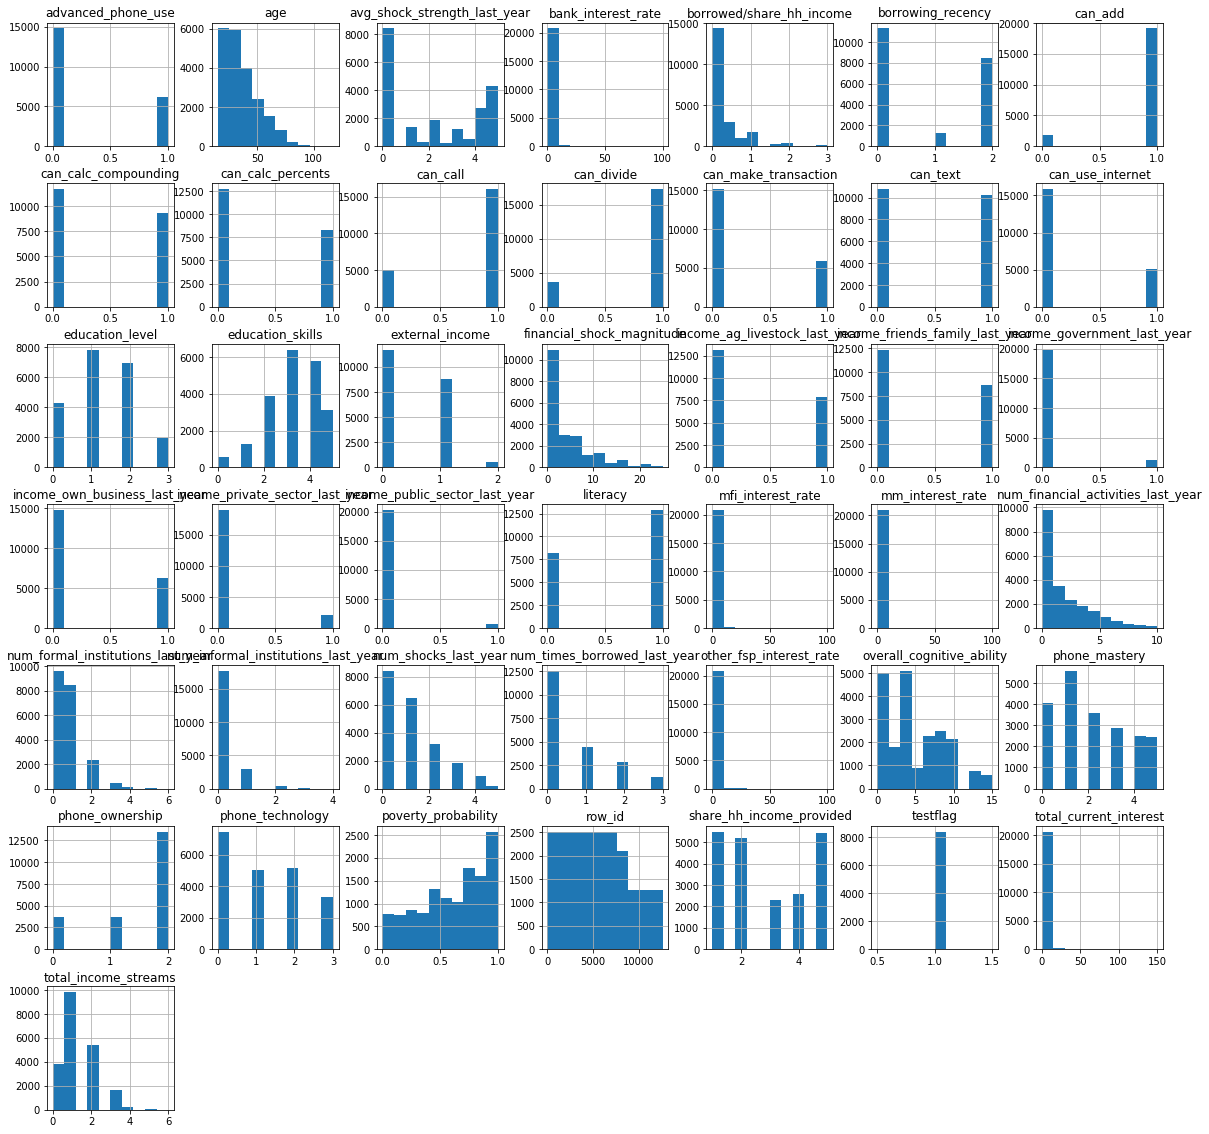

In [93]:
num_data = data.select_dtypes(include = ['float64', 'int64'])
num_data.hist(figsize = (20, 20))

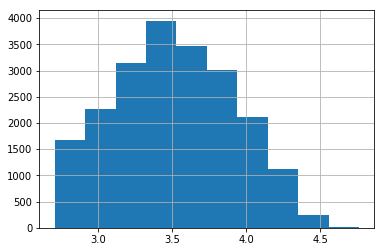

In [94]:
np.log(data['age']).hist()

In [95]:
data['age'] = np.log(data['age'])

# Feature Selection
- Interesting note, this greatly reduced the quality of the predictions, so I have left this in here to refer back to later on, but only as a future resource, and to be able to look at feature importances in a different way to make the black box models more interpretable, like feature_importances_

In [96]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

__Gotta run the modeling code first before this__

In [97]:
## Define the variance threhold and fit the threshold to the feature array. 
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(train_data.select_dtypes(exclude = ['object']))

## Print the support and shape for the transformed features
print(sel.get_support())
print(Features_reduced.shape)

NameError: name 'train_data' is not defined

In [ ]:
## Reshape the Label array
labels = np.array(labels)
Labels = labels.reshape(labels.shape[0],)

## Set folds for nested cross validation
nr.seed(988)
feature_folds = ms.KFold(n_splits=5, shuffle = True)

## Perform feature selection by CV with high variance features only
nr.seed(6677)
selector = fs.RFECV(estimator = rf, cv = feature_folds,
                      scoring = 'r2')
selector = selector.fit(Features_reduced, Labels)
selector.support_ 

In [ ]:
selector.ranking_

In [ ]:
Features_reduced = selector.transform(Features_reduced)
Features_reduced.shape

In [ ]:
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.title('Mean AUC by number of features')
plt.ylabel('AUC')
plt.xlabel('Number of features')

In [ ]:
Features_reduced = pd.DataFrame(Features_reduced)

# Modeling

In [ ]:
#modeling packages for data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
import lightgbm as lgb

#visualize residuals
from yellowbrick.regressor import ResidualsPlot

In [ ]:
#dropping nominal row id feature, its completely unnecessary
data.drop('row_id', axis = 1, inplace = True)

In [ ]:
#dummy code our data
data_dummies = pd.get_dummies(data)

#split train and test
train_data = data_dummies[data_dummies['testflag'] != 1]
test_data = data_dummies[data_dummies['testflag'] == 1]

# train_data = data[data['testflag'] != 1]
# test_data = data[data['testflag'] == 1]

#drop target from test
test_data.drop('poverty_probability', axis=1, inplace=True)

#drop testflag from data
test_data.drop('testflag', axis=1, inplace=True)
train_data.drop('testflag', axis=1, inplace=True)

In [ ]:
#specify our features and target

features = train_data.drop('poverty_probability', axis = 1)
labels = train_data['poverty_probability']

# #Label Encoding
# for x in features.columns[features.dtypes == 'object']:
#     features[x] = features[x].factorize()[0]

#scale features (if this changes our outcome, which it really doesn't)
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

#split training data into train and test set for validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .2, random_state = 45)

#scoring function for regression
def get_score(model):
        '''
        Fits the model and returns a series containing the RMSE, MAE, and R^2
        '''
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import time

        startTime = time.time()  # Getting training time
        
        # Fits with training set
        model.fit(X_train, y_train)
        totalTime = time.time() - startTime
        predictions = model.predict(X_test)
        
        r2 = model.score(X_test, y_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
            
        score_results = pd.Series([r2, rmse, mae, totalTime], index=['R^2', 'RMSE', 'MAE', 'TrainingTime(sec)'])
        
        return score_results

# Linear Regression

In [ ]:
lm = LinearRegression()
lmScore = get_score(lm)
lmScore

In [ ]:
visualizer = ResidualsPlot(lm)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

# Gradient Boosting
- really similar to LightGBM, but just wanted to see if they look at feature importances the same

In [ ]:
gbt = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=1)
gbtScore = get_score(gbt)
gbtScore

In [ ]:
visualizer = ResidualsPlot(gbt)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [ ]:
feature_importances = pd.Series(gbt.feature_importances_, index=features.columns)
feature_importances.nlargest(20).plot(kind='barh')

# LightGBM

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
mlgbScore = get_score(model_lgb)
mlgbScore

In [ ]:
visualizer = ResidualsPlot(model_lgb)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [ ]:
feature_importances = pd.Series(model_lgb.feature_importances_, index=features.columns)
feature_importances.nlargest(20).plot(kind='barh')

# Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=2)
rfScore = get_score(rf)
rfScore

In [ ]:
visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

__Interesting to see the differences between feature importances in GradientBoosting, LightGBM, and RandomForest__

In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=features.columns)
feature_importances.nlargest(20).plot(kind='barh')

# Ensembling 

__NOTE: Our scoring metric for this competition is R2, and a "good" R2 for the final predictions score is anything above .41, the leader sits at .43, and my model is 
scoring at .4423 on the training set__
- increasing our train-test-split to 80/20 brought the score up a lot

In [ ]:
stacked_pred = (rf.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test) + rf.predict(X_test) + 
               model_lgb.predict(X_test) + rf.predict(X_test) + rf.predict(X_test) + model_lgb.predict(X_test) + model_lgb.predict(X_test))/10

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
r2_score(y_test, stacked_pred)
mean_absolute_error(y_test, stacked_pred)
np.sqrt(mean_squared_error(y_test, stacked_pred))

In [ ]:
final_pred = (rf.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(test_data) + rf.predict(test_data) + 
               model_lgb.predict(test_data) + rf.predict(test_data) + rf.predict(test_data) + model_lgb.predict(test_data) + model_lgb.predict(test_data))/10

In [ ]:
submissions_df = pd.DataFrame(final_pred)
submissions_df.to_csv('final_stacked_submissions.csv')

In [ ]:
submissions_df.shape

# K-Fold Cross Validation
Cross-validation

Cross-validation is conceptually running a bunch of test/train split evaluations and taking the average of those results.
The key difference is that cross-validation is done systemically to ensure the test/train split evaluations aren't run on the same data.

Steps for K-fold cross-validation:
1. Split the dataset into K equal partitions (or "folds").
2. Use fold 1 as the testing set and the union of the other folds as the training set.
3. Calculate testing accuracy.
4. Repeat steps 2 and 3 K times, using a different fold as the testing set each time.
5. Use the average testing accuracy as the estimate of out-of-sample accuracy.

In [ ]:
import numpy.random as nr
from sklearn.model_selection import cross_val_score 
import sklearn.model_selection as ms

In [ ]:
model_lgb.fit(features, labels)
cv_estimate_lgb = ms.cross_val_score(model_lgb, features, labels, cv = 10)
print('Mean R^2 = %4.3f' % np.mean(cv_estimate))
print('SDT of R^2       = %4.3f' % np.std(cv_estimate))
print('R^2 by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

In [ ]:
xgb.fit(features, labels)
cv_estimate_xgb = ms.cross_val_score(xgb, features, labels, cv = 10)
print('Mean R^2 = %4.3f' % np.mean(cv_estimate_xgb))
print('SDT of R^2       = %4.3f' % np.std(cv_estimate_xgb))
print('R^2 by cv fold')
for i, x in enumerate(cv_estimate_xgb):
    print('Fold %2d    %4.3f' % (i+1, x))

In [ ]:
rf.fit(features, labels)
cv_estimate_rf = ms.cross_val_score(rf, features, labels, cv = 10)
print('Mean R^2 = %4.3f' % np.mean(cv_estimate_rf))
print('SDT of R^2       = %4.3f' % np.std(cv_estimate_rf))
print('R^2 by cv fold')
for i, x in enumerate(cv_estimate_rf):
    print('Fold %2d    %4.3f' % (i+1, x))

In [ ]:
gbt.fit(features, labels)
cv_estimate_gbt = ms.cross_val_score(gbt, features, labels, cv = 5)
print('Mean R^2 = %4.3f' % np.mean(cv_estimate_gbt))
print('SDT of R^2       = %4.3f' % np.std(cv_estimate_gbt))
print('R^2 by cv fold')
for i, x in enumerate(cv_estimate_gbt):
    print('Fold %2d    %4.3f' % (i+1, x))

# Nested Cross-Validation
- First, I want to tune the LightGBM model for n_estimators (I might tune for other hyperparameters later depending on this model's score)
    - This improved our score by .50!
- Second, I am going to tune the Random Forest for max_features and min_samples_leaf

__LightGBM Hyperparameter Optimization__

In [ ]:
import numpy.random as nr
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as model_selection
# this defines the inner cross-validation
nr.seed(123)
inside = model_selection.KFold(n_splits=10, shuffle = True)

#this defines outer cross-validation
nr.seed(321)
outside = model_selection.KFold(n_splits=10, shuffle = True)


## Define the dictionary for the grid search and the model object to search on
param_grid = {"n_estimators": list(range(100, 4000, 10))}

## Perform the grid search over the parameters
nr.seed(4455)
tuned_lgb = model_selection.RandomizedSearchCV(estimator = model_lgb, param_distributions = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'r2',
                      return_train_score = True)

tuned_lgb.fit(features, labels)
print(tuned_lgb.best_estimator_.n_estimators)

In [ ]:
print(tuned_lgb.best_estimator_.n_estimators)

In [ ]:
nr.seed(498)
cv_estimate = model_selection.cross_val_score(tuned_lgb, features, labels, 
                                 cv = outside) # Use the outside folds

print('Mean R^2 = %4.3f' % np.mean(cv_estimate))
print('SDT of R^2       = %4.3f' % np.std(cv_estimate))
print('R^2 by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

__Second go at LightGBM__
- I am going to tune the max_depth and learning_rate to see if there is any change as well
    - a little better performance

In [98]:
import numpy.random as nr
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as model_selection
# this defines the inner cross-validation
nr.seed(1234)
inside = model_selection.KFold(n_splits=10, shuffle = True)

#this defines outer cross-validation
nr.seed(4321)
outside = model_selection.KFold(n_splits=10, shuffle = True)


## Define the dictionary for the grid search and the model object to search on
param_grid = {"n_estimators": list(range(100, 4000, 10)), 'max_depth':list(range(-1, 100, 1)), 'learning_rate': (.01, .05, .10, .50, .60, .70, .80, .90, 1)}

## Perform the grid search over the parameters
nr.seed(4465)
tuned_lgb_2 = model_selection.RandomizedSearchCV(estimator = model_lgb, param_distributions = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'r2',
                      return_train_score = True)

tuned_lgb_2.fit(features, labels)
print(tuned_lgb_2.best_estimator_.n_estimators)
print(tuned_lgb_2.best_estimator_.max_depth)
print(tuned_lgb_2.best_estimator_.learning_rate)

NameError: name 'model_lgb' is not defined

In [ ]:
nr.seed(478)
cv_estimate_lgb_2 = model_selection.cross_val_score(tuned_lgb_2, features, labels, 
                                 cv = outside) # Use the outside folds

print('Mean R^2 = %4.3f' % np.mean(cv_estimate_lgb_2))
print('SDT of R^2       = %4.3f' % np.std(cv_estimate_lgb_2))
print('R^2 by cv fold')
for i, x in enumerate(cv_estimate_lgb_2):
    print('Fold %2d    %4.3f' % (i+1, x))

__Random Forest Hyperparamter Optimization__

In [ ]:
import numpy.random as nr
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as model_selection
# this defines the inner cross-validation
nr.seed(1234)
inside2 = model_selection.KFold(n_splits=10, shuffle = True)

#this defines outer cross-validation
nr.seed(3221)
outside2 = model_selection.KFold(n_splits=10, shuffle = True)


## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_features": list(range(1, 90, 1)), "n_estimators":list(range(100, 4000, 10)), "min_samples_leaf":list(range(1, 5, 1))}

## Perform the grid search over the parameters
nr.seed(4455)
tuned_rf = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                      cv = inside2, # Use the inside folds
                      scoring = 'r2',
                      return_train_score = True)

tuned_rf.fit(features, labels)
print(tuned_rf.best_estimator_.max_features)
print(tuned_rf.best_estimator_.n_estimators)
print(tuned_rf.best_estimator_.min_samples_leaf)

In [ ]:
nr.seed(4984)
cv_estimate_tuned_rf = model_selection.cross_val_score(tuned_rf, features, labels, 
                                 cv = outside2) # Use the outside folds

print('Mean R^2 = %4.3f' % np.mean(cv_estimate_tuned_rf))
print('SDT of R^2       = %4.3f' % np.std(cv_estimate_tuned_rf))
print('R^2 by cv fold')
for i, x in enumerate(cv_estimate_tuned_rf):
    print('Fold %2d    %4.3f' % (i+1, x))

__Now I am going to add the tuned models together for final predictions, I could also add in the other cross-validated models, but the submission limit on DrivenData is 3 per day, so I don't have a ton of opportunities to test out combinations of models that have been fit on the entire data set__

In [ ]:
stacked_pred_cv = (tuned_rf.predict(test_data) + tuned_lgb_2.predict(test_data))/2

In [ ]:
stacked_pred_cv = pd.DataFrame(stacked_pred_cv)
stacked_pred_cv.to_csv('cv_predictions.csv')

# Word to the wise: Hyperparameter tuning is extremely helpful to model performance, in addition to giving a better idea of model generalization to new data
- my LightGBM and Random Forest performed significantly better after tuning a couple of hyperparameters

__Throwing a classic 'fizzbuzz' challenge in for s and g's__

In [ ]:
for x in list(range(1, 101)):
    if x % 2 == 0:
        print('fizz')
    else:
        print('buzz')